Dual-reservoir model starting...
Exchange rates: f_r_b = 0.02, f_b_r = 0.0002 (same for S and R)
Initial conditions: S_b=10.0, R_b=10.0, S_res=1000.0, R_res=1000.0, N0=5000.0
Vancomycin starts at: 300 h, Linezolid starts at: 396 h
Linezolid ends at: 696 h


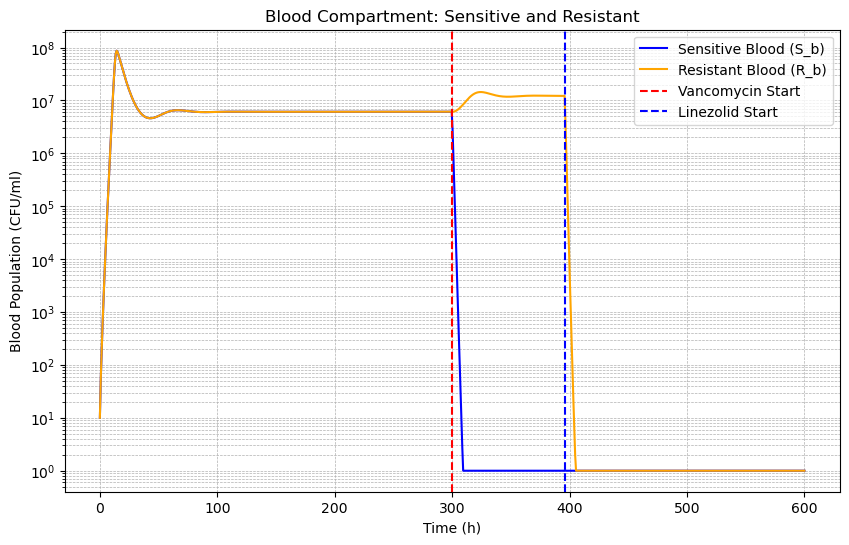

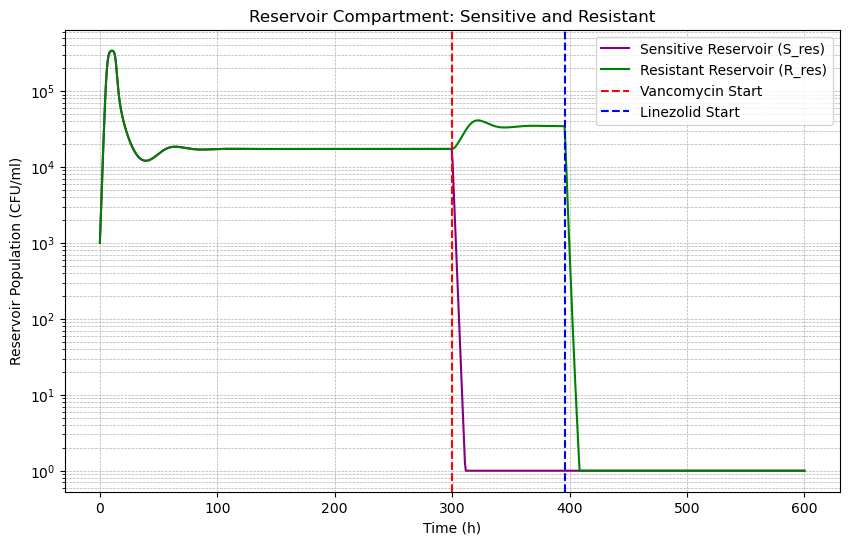

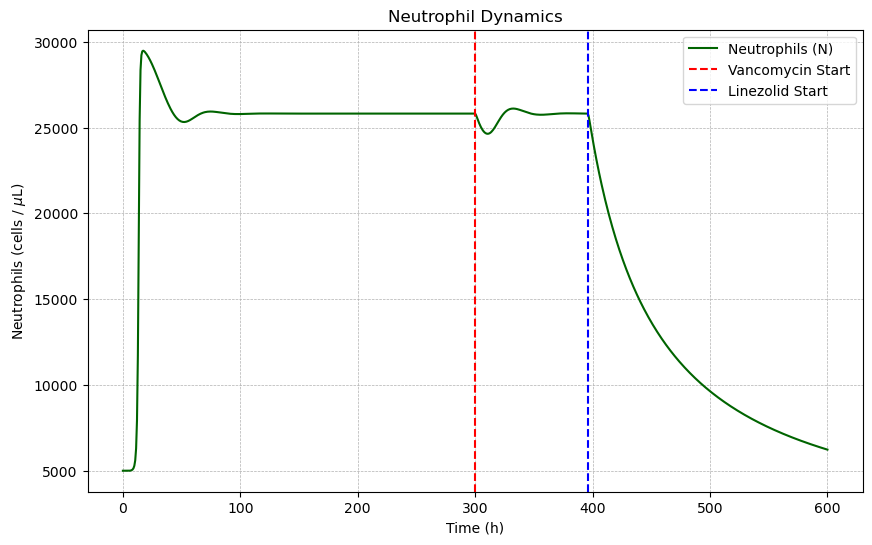

In [3]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- Pharmacokinetic Model (reused) ---
class PharmacokineticModel:
    def __init__(self):
        # Vancomycin
        self.van_dose = 1200
        self.van_interval = 6
        self.van_duration = 96
        self.van_ke = 0.173
        self.van_volume = 50
        # Linezolid
        self.lzd_dose = 800
        self.lzd_interval = 12
        self.lzd_duration = 300
        self.lzd_ke = 0.116
        self.lzd_volume = 45

    def concentration_function(self, drug_type, total_time_h, start_h=0):
        if drug_type == 'vancomycin':
            dose, interval, duration, ke, volume = self.van_dose, self.van_interval, self.van_duration, self.van_ke, self.van_volume
        else:
            dose, interval, duration, ke, volume = self.lzd_dose, self.lzd_interval, self.lzd_duration, self.lzd_ke, self.lzd_volume

        t_points = np.linspace(0, total_time_h, int(total_time_h*10)+1)
        conc = np.zeros_like(t_points)
        for dt in np.arange(start_h, start_h + duration, interval):
            mask = t_points >= dt
            conc[mask] += (dose/volume) * np.exp(-ke*(t_points[mask]-dt))
        conc[t_points < start_h] = 0

        def conc_func(t):
            return np.interp(t, t_points, conc)
        return conc_func

# --- Immune Response Model (aligned with current project) ---
class ImmuneResponse:
    def __init__(self, rho_N=2.1e-2, N_MAX=30000, delta_N=2e-2, kill_N=5e-5, N0=5000, rho_slope=1e-7):
        self.rho_N = rho_N
        self.N_MAX = N_MAX
        self.delta_N = delta_N
        self.kill_N = kill_N
        self.N0 = N0
        # Linear sensitivity of recruitment to bacterial load (per CFU/ml per hour)
        self.rho_slope = rho_slope

    def compute(self, N, B_total, t=None):
        """Option B: growth-rate increases linearly with total bacteria without an extra B_total factor.
        rho_eff = rho_N + rho_slope * B_total
        dN = rho_eff * N * (1 - N/N_MAX) - delta_N * N
        """
        B = max(B_total, 0.0)
        rho_eff = self.rho_N + self.rho_slope * B
        # prevent negative effective growth rate if slope < 0 or B small
        # rho_eff = max(rho_eff, 0.0)
        dN = rho_eff * N * (1 - N/self.N_MAX) - self.delta_N * N
        immune_effect = self.kill_N * N
        # Enforce floor: do not allow N to decrease below initial N0
        if N <= self.N0 and dN < 0:
            dN = 0.0
        return dN, immune_effect

# --- ODE system: Blood and Reservoir for S and R, plus Neutrophils ---
# State vector y = [S_b, R_b, S_res, R_res, N]
def dual_reservoir_model(y, t, params, van_func, lzd_func, immune_model):
    S_b, R_b, S_res, R_res, N = y

    # Non-negativity clamp
    S_b = max(S_b, 0.0)
    R_b = max(R_b, 0.0)
    S_res = max(S_res, 0.0)
    R_res = max(R_res, 0.0)
    N = max(N, 0.0)

    # Drugs
    V = max(0.0, van_func(t))
    L = max(0.0, lzd_func(t))

    # Totals for effects
    B_total = S_b + R_b + S_res + R_res

    # PD effects
    h_V = h_L = 1.0
    linezolid_inhibition = (params['Emax_l'] * L**h_L) / (params['EC50_L']**h_L + L**h_L)
    vancomycin_kill = (params['Emax_v'] * V**h_V) / (params['EC50_V']**h_V + V**h_V)

    # Logistic (separate for blood vs reservoir carrying capacity)
    logistic_blood = (1 - (S_b + R_b) / params['B_max_blood'])
    logistic_res = (1 - (S_res + R_res) / params['K_res_total'])

    # Immune
    dN, immune_eff = immune_model.compute(N, B_total, t)

    # Immune killing per compartment
    imm_S_b = immune_eff * S_b
    imm_R_b = immune_eff * R_b
    imm_S_res = immune_eff * S_res
    imm_R_res = immune_eff * R_res

    # Exchange rates (same for both S and R)
    f_r_b = params['f_r_b']  # reservoir -> blood
    f_b_r = params['f_b_r']  # blood -> reservoir

    # Dynamics - Blood (S and R)
    dS_b = (
        params['rho_S'] * S_b * logistic_blood
        - params['delta'] * S_b
        - imm_S_b
        - vancomycin_kill * S_b
        - linezolid_inhibition * S_b
        + f_r_b * S_res - f_b_r * S_b
    )
    dR_b = (
        params['rho_R'] * R_b * logistic_blood
        - params['delta'] * R_b
        - imm_R_b
        # Vancomycin primarily targets S in this model
        - linezolid_inhibition * R_b
        + f_r_b * R_res - f_b_r * R_b
    )

    # Dynamics - Reservoir (S and R)
    dS_res = (
        params['rho_res_S'] * S_res * logistic_res
        - params['delta_res'] * S_res
        - imm_S_res
        - 0.5 * vancomycin_kill * S_res
        - 0.5 * linezolid_inhibition * S_res
        - f_r_b * S_res + f_b_r * S_b
    )
    dR_res = (
        params['rho_res_R'] * R_res * logistic_res
        - params['delta_res'] * R_res
        - imm_R_res
        # Vancomycin kill negligible on R in this model
        - 0.5 * linezolid_inhibition * R_res
        - f_r_b * R_res + f_b_r * R_b
    )

    return [dS_b, dR_b, dS_res, dR_res, dN]

if __name__ == "__main__":
    print("Dual-reservoir model starting...")

    # --- Simulation setup ---
    total_h = 600
    pk = PharmacokineticModel()
    immune_model = ImmuneResponse(N0=5000, rho_slope=1e-8)

    vanco_start = 300
    lzd_start = vanco_start + pk.van_duration
    lzd_end = lzd_start + pk.lzd_duration

    van_func = pk.concentration_function('vancomycin', total_h, vanco_start)
    lzd_func = pk.concentration_function('linezolid', total_h, lzd_start)

    # Parameters
    params = {
        # Growth/Death
        'rho_S': 1.47,
        'rho_R': 1.47,
        'delta': 0.179,
        # PD
        'Emax_v': 1.74,
        'Emax_l': 1.97,
        'EC50_V': 0.245,
        'EC50_L': 0.56,
        # Carrying capacities
        'B_max_blood': 4e12,
        'K_res_total': 1e6,  # total reservoir capacity for S_res + R_res
        # Reservoir intrinsic dynamics
        'rho_res_S': 1.47,
        'rho_res_R': 1.47,
        'delta_res': 0.179,
        # Exchange (same for S and R)
        'f_r_b': 0.02,   # reservoir -> blood
        'f_b_r': 0.0002,   # blood -> reservoir
    }

    # Initial conditions [S_b, R_b, S_res, R_res, N]
    y0 = [1e1, 1e1, 1e3, 1e3, immune_model.N0]

    # Time grid
    t_eval = np.linspace(0, total_h, 800)

    # Solve
    solution = odeint(dual_reservoir_model, y0, t_eval, args=(params, van_func, lzd_func, immune_model))

    # Extractonly for plotting log scale because log(0) is undefined and 
    #negative values will cause overflow
    S_b = np.clip(solution[:, 0], 1, None)
    R_b = np.clip(solution[:, 1], 1, None)
    S_res = np.clip(solution[:, 2], 1, None)
    R_res = np.clip(solution[:, 3], 1, None)
    N = solution[:, 4]

    # Summary prints
    print(f"Exchange rates: f_r_b = {params['f_r_b']}, f_b_r = {params['f_b_r']} (same for S and R)")
    print(f"Initial conditions: S_b={y0[0]:.1f}, R_b={y0[1]:.1f}, S_res={y0[2]:.1f}, R_res={y0[3]:.1f}, N0={y0[4]:.1f}")
    print(f"Vancomycin starts at: {vanco_start} h, Linezolid starts at: {lzd_start} h")
    print(f"Linezolid ends at: {lzd_end} h")

    # Plots
    plt.figure(figsize=(10,6))
    plt.plot(t_eval, S_b, label='Sensitive Blood (S_b)', color='blue')
    plt.plot(t_eval, R_b, label='Resistant Blood (R_b)', color='orange')
    plt.yscale('log')
    plt.xlabel('Time (h)')
    plt.ylabel('Blood Population (CFU/ml)')
    plt.title('Blood Compartment: Sensitive and Resistant')
    plt.axvline(vanco_start, color='red', linestyle='--', label='Vancomycin Start')
    plt.axvline(lzd_start, color='blue', linestyle='--', label='Linezolid Start')
    plt.grid(True, which="both", ls='--', lw=0.5)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(t_eval, S_res, label='Sensitive Reservoir (S_res)', color='purple')
    plt.plot(t_eval, R_res, label='Resistant Reservoir (R_res)', color='green')
    plt.yscale('log')
    plt.xlabel('Time (h)')
    plt.ylabel('Reservoir Population (CFU/ml)')
    plt.title('Reservoir Compartment: Sensitive and Resistant')
    plt.axvline(vanco_start, color='red', linestyle='--', label='Vancomycin Start')
    plt.axvline(lzd_start, color='blue', linestyle='--', label='Linezolid Start')
    plt.grid(True, which="both", ls='--', lw=0.5)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(t_eval, N, color='darkgreen', label='Neutrophils (N)')
    plt.xlabel('Time (h)')
    plt.ylabel(r'Neutrophils (cells / $\mu$L)')
    plt.title('Neutrophil Dynamics')
    plt.axvline(vanco_start, color='red', linestyle='--', label='Vancomycin Start')
    plt.axvline(lzd_start, color='blue', linestyle='--', label='Linezolid Start')
    plt.grid(True, ls='--', lw=0.5)
    plt.legend()
    plt.show()
